# 자동화된 소프트웨어 개발팀 에이전트 만들기

## 필요 라이브러리 설치

In [1]:
##%pip install langgraph

## 필요 라이브러리 불러오기

In [2]:
import os
from typing import TypedDict, Annotated, Literal
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END, START

## GPT 모델 설정

In [3]:
from dotenv import load_dotenv
load_dotenv()

llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.7)

## 상태 정의
- 각 에이전트가 공유할 데이터 스키마

In [4]:
class State(TypedDict):
    requirement: str  # 사용자 요청 사항
    plan: str         # PM이 작성한 기획서
    code: str         # 개발자가 작성한 코드
    review: str       # 리뷰어의 피드백
    decision: str     # 리뷰 결과
    count: int        # 반복 횟수

## 노드 정의

In [5]:
# PM 노드 함수
def pm_node(state: State):
    print("\n[PM] 기획서 작성 중")
    requirement = state["requirement"]

    # PM 에이전트 시스템 프롬프트 작성
    prompt = f"사용자의 요청: '{requirement}'\n이 요청을 바탕으로 소프트웨어 개발을 위한 간단한 기획서를 작성해줘"
    response = llm.invoke([SystemMessage(content="너는 유능한 IT PM이야"), HumanMessage(content=prompt)])

    return {"plan": response.content, "count": 1}

In [6]:
# 개발자 노드 함수
def coder_node(state: State):
    print("\n[Coder] 코드 작성 혹은 수정 중")
    plan = state["plan"]
    review = state.get("review", "") # 이전 리뷰가 있다면 가져옴

    # 개발자 에이전트 시스템 프롬프트 작성
    if review:
        prompt = f"기획서: {plan}\n\n리뷰어 피드백: {review}\n\n피드백을 반영하여 코드를 수정해줘."
    else:
        prompt = f"기획서: {plan}\n\n이 기획서에 맞춰 파이썬 코드를 작성해줘."

    response = llm.invoke([SystemMessage(content="너는 숙련된 파이썬 개발자야. 코드만 깔끔하게 출력해줘."), HumanMessage(content=prompt)])

    return {"code": response.content}

- 리뷰어 에이전트를 통해 그래프의 순환 구조를 확인하기 위해 2번까지 거절

In [7]:
# 리뷰어 노드 함수
def reviewer_node(state: State):
    print("\n[Reviewer] 코드 검토 중")
    code = state["code"]
    count = state["count"]

    if count > 3: # 3번 이상 반복되면 강제 승인 (무한 루프 방지)
        return {"decision": "approve", "review": "반복 횟수 초과로 승인합니다."}

    # 리뷰어 에이전트 시스템 프롬프트 작성
    prompt = f"다음 코드를 검토해줘:\n{code}\n\n버그가 있거나 개선이 필요하면 'REJECT'로 시작하는 피드백을 주고, 완벽하면 'APPROVE'라고만 답해."
    response = llm.invoke([SystemMessage(content="너는 꼼꼼한 코드 리뷰어야."), HumanMessage(content=prompt)])

    review_content = response.content
    decision = "approve" if "APPROVE" in review_content.upper() else "reject"
    print(f"--> 판정: {decision}")

    return {"decision" : "reject", "review" : f"테스트상 {count}번 재검토 합니다.", "count" : count +1}
    # return {"decision": decision, "review": review_content, "count": count + 1}

## 그래프 정의
- StateGraph를 생성할 때 상태의 스키마로 State 전달
- 그래프가 처리할 데이터의 형태를 정의

In [8]:
graph = StateGraph(State)

## 노드 정의

In [9]:
graph.add_node("PM", pm_node)
graph.add_node("Coder", coder_node)
graph.add_node("Reviewer", reviewer_node)

## 엣지 정의

In [10]:
graph.add_edge(START, "PM")
graph.add_edge("PM", "Coder")
graph.add_edge("Coder", "Reviewer")

### 조건부 엣지 함수 정의
- `Literal` : `typing` 모듈 기능으로 변수나 반환 값이 특정 값들 중 하나만 가질 수 있음을 제한함

In [11]:
def check_review(state: State) -> Literal["Coder", "end"]:
    if state["decision"] == "approve":
        return "end"
    return "Coder"

### Reviewer의 결정에 따라 분기하는 조건부 엣지 추가

In [12]:
graph.add_conditional_edges(
    "Reviewer",
    check_review,
    {
        "Coder": "Coder",
        "end": END
    }
)

# 그래프 컴파일
app = graph.compile()

## 그래프 시각화

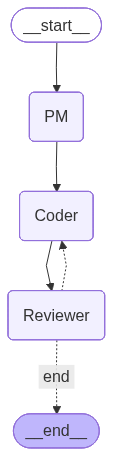

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    pass

## 그래프 실행

In [16]:
inputs = {"requirement": "윈도우 환경에서도 완벽하게 돌아갈수있는 실제 게임처럼 스테이지 및 점수도 확인가능한 테트리스를 만들어봐줘"}
final_code = ""
for output in app.stream(inputs):
    for key, value in output.items():
        print(f"Finished: {key}\n {value}")
        if "code" in value:
                final_code = value["code"]

# 최종 결과 확인
print("\n[최종 완성 코드]")
print(final_code)


[PM] 기획서 작성 중
Finished: PM
 {'plan': '### 프로젝트 기획서: 윈도우 환경에서 동작하는 테트리스 게임\n\n#### 1. 프로젝트 개요\n- **프로젝트 명**: 윈도우 테트리스 게임\n- **목표**: 사용자가 윈도우 환경에서 실행할 수 있는 실제 게임처럼 스테이지와 점수를 확인할 수 있는 테트리스 게임 개발\n\n#### 2. 주요 기능\n- **게임 화면**: 테트리스 블록이 쌓이는 메인 게임 화면\n- **조작 기능**:\n  - 화살표 키를 이용한 블록 이동 및 회전\n  - 스페이스바를 이용한 블록 즉시 하강\n- **게임 상태**:\n  - 현재 진행 중인 스테이지 표시\n  - 현재 점수 및 최고 점수 표시\n  - 게임 오버 시 재시작 및 종료 옵션 제공\n- **레벨 업**: 특정 점수에 도달 시 스테이지 업 (블록이 더 빠르게 떨어짐)\n- **사운드 효과**: 블록이 쌓일 때, 게임 오버 시 등의 효과음 제공\n\n#### 3. 기술 스택\n- **프로그래밍 언어**: C# (Windows Forms 또는 WPF)\n- **IDE**: Visual Studio\n- **그래픽 라이브러리**: GDI+ (Windows Forms의 경우) 또는 DirectX/WPF (WPF의 경우)\n- **버전 관리**: Git\n\n#### 4. 개발 일정\n- **1주차**: 요구사항 분석 및 기획\n- **2주차**: 기본 UI 설계 및 게임 로직 구현\n- **3주차**: 조작 기능 및 점수 시스템 구현\n- **4주차**: 레벨 업 시스템 및 사운드 효과 추가\n- **5주차**: 테스트 및 버그 수정\n- **6주차**: 최종 점검 및 배포\n\n#### 5. 테스트 계획\n- **유닛 테스트**: 게임 로직 및 점수 계산 부분에 대한 단위 테스트\n- **통합 테스트**: 전체 게임 흐름에 대한 테스트\n- **사용자 테스트**: 실제 사용자로부터 피드백 수집 및 수정\n\n#### 6. 배포 계획\n- **배포